In [13]:
# 读取数据
import time
import pandas as pd #数据分析
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
#混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
time_start=time.time()
#读取training data
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]
data= pd.read_csv("E:\Pycharm\Intrusion_Detection\kddcup.data_10_percent.csv",  header=None,names = col_names)

#去重
data_1=data.drop_duplicates()

#one-hot
dummies_protocol = pd.get_dummies(data_1["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_1["flag"], prefix='flag')
data_2 = pd.concat([data_1, dummies_protocol,dummies_flag], axis=1)
# data_2
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
feature_selection=["duration",
    "dst_bytes","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_access_files",
    "num_outbound_cmds","is_guest_login","rerror_rate","srv_diff_host_rate",
    "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate",
    "protocol_icmp","protocol_tcp","protocol_udp",
    "flag_OTH","flag_REJ","flag_RSTO","flag_RSTOS0","flag_RSTR",
    "flag_S0","flag_S1","flag_S2","flag_S3","flag_SF","flag_SH"]
X_3=data_2[feature_selection]
y_3=data_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop."]
probe=["satan.","portsweep.","ipsweep.","nmap."]
for i in u2r:
    y_3[y_3==i]='U2R' #u2r
for i in r2l:
    y_3[y_3==i]='R2L' #r2l
for i in dos:
    y_3[y_3==i]='DOS'  #dos
for i in probe:
    y_3[y_3==i]='Probing' #probe
y_3[y_3=="normal."]='Normal' #normal
y_3=np.array(y_3)  #变成array格式，一维

#读取test data
data_test= pd.read_csv("E:\Pycharm\Intrusion_Detection\corrected.csv",  header=None,names = col_names)
#去重
data_test=data_test.drop_duplicates()
#one-hot
dummies_protocol = pd.get_dummies(data_test["protocol_type"], prefix='protocol')
dummies_flag = pd.get_dummies(data_test["flag"], prefix='flag')
data_test_2 = pd.concat([data_test, dummies_protocol,dummies_flag], axis=1)
#特征选择(by "A feature reduced intrusion detection system using ANN classifier",25个特征）
#建立X,y
X_test=data_test_2[feature_selection]
y_test=data_test_2['label'].copy()   #一维
##y的处理
u2r=["buffer_overflow.","loadmodule.","perl.","rootkit.","httptunnel.","ps.","sqlattack.","xterm."]
r2l=["ftp_write.","imap.","guess_passwd.","phf.","spy.","multihop.","warezmaster.","warezclient.","named.","sendmail."
    ,"snmpgetattack.","snmpguess.","worm.","xlock.","xsnoop."]
dos=["back.","land.","pod.","neptune.","smurf.","teardrop.","apache2.","mailbomb.","processtable.","udpstorm."]
probe=["satan.","portsweep.","ipsweep.","nmap.","mscan.","saint."]
for i in u2r:
    y_test[y_test==i]="U2R"
for i in r2l:
    y_test[y_test==i]="R2L"
for i in dos:
    y_test[y_test==i]="DOS"
for i in probe:
    y_test[y_test==i]="Probing"
y_test[y_test=="normal."]="Normal"
y_test=np.array(y_test)  #变成array格式，一维
#过采样+欠采样 smote+enn
from imblearn.combine import SMOTEENN
oversampler=SMOTEENN(random_state=42,n_neighbors=100)
X_SMOTEENN,y_se=oversampler.fit_sample(X_3,y_3)
X_test_SMOTEENN,y_test_se=oversampler.fit_sample(X_test,y_test)
#标准化
from sklearn.preprocessing import StandardScaler
scaler_se=StandardScaler().fit(X_SMOTEENN)
X_se=scaler_se.transform(X_SMOTEENN)  #X是ndarray
X_test_se=scaler_se.transform(X_test_SMOTEENN)
##建立模型
clf_4 = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV
x=range(10,500,10)
param_test1 = {'n_estimators':x}
gsearch1 = GridSearchCV(estimator = clf_4,
param_grid = param_test1, scoring='accuracy',cv=10)
gsearch1.fit(X_se,y_se)
print(gsearch1.cv_results_)
# #验证测试样本
# clf_4.fit(X_se,y_se)
# preditions_smoteenn=clf_4.predict(X_test_se)
#
# time_end=time.time()
# print(time_end-time_start,'s')
# #混淆矩阵
# from sklearn.metrics import confusion_matrix
# cnf_matrix_smoteenn=confusion_matrix(y_test_se,preditions_smoteenn)
# class_names=['DOS','Normal','Probing','R2L','U2R']
# plt.figure()
# plt.figure()
# plot_confusion_matrix(cnf_matrix_smoteenn,classes=class_names,title='SMOTE+ENN Confusion matrix')
# #分类报告
# from sklearn.metrics import classification_report
# print(" SMOTE+ENN")
# print(classification_report(y_test_se,preditions_smoteenn,target_names=class_names,digits=6))
#
# plt.show()

C:\Users\Jason\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\Jason\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


{'std_train_score': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'split5_train_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'split5_test_score': array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]), 'std_test_score': array([  4.35450381e-05,   5.54791738e-05,   4.90266844e-05,
         4.59331835e-05,   4.9026

In [14]:
y=gsearch1.cv_results_['mean_test_score']
print(y)

[ 0.99996382  0.99996641  0.99997416  0.99997933  0.99997416  0.99997674
  0.99997416  0.99997674  0.99997416  0.99997674  0.99997416  0.99997416
  0.99997674  0.99997416  0.99997674  0.99997416  0.99997674  0.99997674
  0.99997416  0.99997674  0.99997674  0.99997674  0.99997674  0.99997674
  0.99997674  0.99997674  0.99997674  0.99997416  0.99997674  0.99997416
  0.99997674  0.99997674  0.99997933  0.99997674  0.99997674  0.99997416
  0.99997674  0.99997933  0.99997674  0.99997674  0.99997416  0.99997416
  0.99997674  0.99997674  0.99997674  0.99997416  0.99997674  0.99997674
  0.99997674]


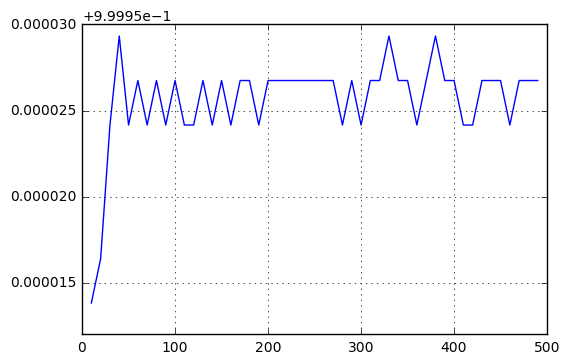

In [14]:
plt.figure()
plt.grid()
plt.plot(x,y)
plt.show()

In [19]:
score=[]
score.append(1)
print(score)

[1]


In [20]:
score.append(2)
print(score)

[1, 2]
